## Recurrent Neural Networks
- Feedforward neural networks (e.g. MLPs and CNNs) are powerful, but they are not optimized to handle "sequential" data
- In other words, they do not possess "memory" of previous inputs
- For instance, consider the case of translating a corpus. You need to consider the **"context"** to guess the next word to come forward

<br>
- RNNs are suitable for dealing with sequential format data since they have **"recurrent"** structure
- To put it differently, they keep the **"memory"** of earlier inputs in the sequence
</br>
<img src="http://www.wildml.com/wp-content/uploads/2015/09/rnn.jpg" style="width: 600px"/>

<br>
- However, in order to reduce the number of parameters, every layer of different time steps shares same parameters
</br>

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" style="width: 600px"/>

# Understanding RNN structure
- Distinguished from feedforward nets, RNNs are structures that can well handle data with "sequential" format by preserving previous "state" 
- Thus, grasping concepts of **"sequences"** and (hidden) **"states"** in RNNs is crucial

In [1]:
import numpy as np
from keras.models import Model, Sequential
from keras.layers import *

Using TensorFlow backend.


## 1. SimpleRNN 

Input shape of SimpleRNN should be 3D tensor => (batch_size, timesteps, input_dim)
- **batch_size**: ommitted when creating RNN instance (== None). Usually designated when fitting model.
- **timesteps**: number of input sequence per batch
- **input_dim**: dimensionality of input sequence

In [2]:
# for instance, consider below array
x = np.array([[
             [1,    # => input_dim 1
              2,    # => input_dim 2 
              3],   # => input_dim 3     # => timestep 1                            
             [4, 5, 6]                   # => timestep 2
             ],                                  # => batch 1
             [[7, 8, 9], [10, 11, 12]],          # => batch 2
             [[13, 14, 15], [16, 17, 18]]        # => batch 3
             ])

In [3]:
print('(Batch size, timesteps, input_dim) = ',x.shape)

(Batch size, timesteps, input_dim) =  (3, 2, 3)


In [5]:
x = np.random.normal(0,1,(100,5))
y = 3*x

In [15]:
def const_init(value):
    def kk(shape):
        print(shape)
        return value*np.ones(shape)
    return kk

def random_init(shape):
    print(shape)
    return np.random.normal(0,1,shape)

x = Input(shape = (2, 1))
# x1 = SimpleRNN(3,activation='linear',
#                kernel_initializer=const_init(3),
#                recurrent_initializer=const_init(2),
#                bias_initializer=const_init(0),
#                return_sequences=1)(x)
x1 = SimpleRNN(3,activation='tanh',
               kernel_initializer=random_init,
               recurrent_initializer=random_init,
               bias_initializer=random_init,
               return_sequences=1)(x)
# rnn = GRU(4)(x)
# rnn = LSTM(4)(x)

model = Model(inputs=x,outputs=x1)
model.summary()
model.compile(optimizer='adam',loss='mse')

(1, 3)
(3, 3)
(3,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 2, 1)              0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 2, 3)              15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.layers[1].get_weights()

[array([[-1.4490637 , -0.13735193,  0.5336439 ]], dtype=float32),
 array([[-0.78034526, -0.5960854 ,  0.69391054],
        [-2.7333298 , -0.38898817,  0.28548482],
        [ 0.8871823 , -0.3189851 ,  0.11166085]], dtype=float32),
 array([ 0.14803763, -0.11748137, -0.89421624], dtype=float32)]

In [17]:
from keras.backend import int_shape
sh = int_shape(x)[1:]
bsh = int_shape(x1)[-1]

In [18]:
X = np.random.normal(0,1,sh)
x_in = np.expand_dims(X,0)
model.predict(x_in)

array([[[ 0.7197003 , -0.04550823, -0.825463  ],
        [-0.32149148, -0.19760409, -0.63718486]]], dtype=float32)

# $$y=h_t=\mathcal{A}(X.W_{xh}+W_{hh}h_{t-1}+b)$$

In [19]:
whx,whh,b = model.layers[1].get_weights()
h = np.zeros(bsh)
for i in range(sh[0]):
#     print(X[i].shape,whx.shape,whh.shape,h.shape)
    hn = np.tanh(np.dot(X[i],whx)+np.dot(whh.T,h)+b)
    h = hn
    print(h)

[ 0.71970023 -0.04550823 -0.82546306]
[-0.32149148 -0.19760407 -0.63718482]


![](https://miro.medium.com/max/332/1*28XR1ajfW1WuTOkjpOc9xA.png)

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" style="width: 500px"/>

<center> Standard RNN </center>

### trainable parameters: h(h+i+1)

In [20]:
# input shape (batch_size, timesteps, input_dim)
rnn = SimpleRNN(50)(Input(shape = (10, 30)))

**return_sequences** = **False** ====> output_shape = **(batch_size = None, num_units)**

In [21]:
rnn = SimpleRNN(50)(Input(shape = (10, 30)))
print(rnn.shape)

(?, 50)


**return_sequences = True** ====> output_shape = **(batch_size, timesteps, num_units)**

In [22]:
rnn = SimpleRNN(50, return_sequences = True)(Input(shape = (10, 30)))
print(rnn.shape)

(?, ?, 50)


## 2. LSTM
- Outputs of LSTM are quite similar to those of RNNs, but there exist subtle differences
- If you compare two diagrams below, there is one more type of "state" that is preserved to next module

![](https://miro.medium.com/max/1003/1*ZX2mVCwMIOhftEaf4FTOYQ.png)

<br>
<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" style="width: 500px"/>

<center> LSTM </center>

![](https://miro.medium.com/max/770/1*6vw1g-HNuOgRYPj-IGhddQ.png)

In addition to "hidden state (ht)" in RNN, there exist "cell state (Ct)" in LSTM structure

<br>
<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png" style="width: 500px"/>

<center> Hidden State </center>

<br>
<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png" style="width: 500px"/>

<center> Cell State </center>

In [23]:
lstm = LSTM(50,)(Input(shape = (10, 30)))
print(lstm.shape)

In [25]:
lstm = LSTM(50, return_sequences = True)(Input(shape = (10, 30)))
print(lstm.shape)         # shape of output

(?, ?, 50)


## 3. GRU
- GRU, Popular variant of LSTM, does not have cell state
- Hence, it has only hidden state, as simple RNN

![](https://miro.medium.com/max/862/1*GSZ0ZQZPvcWmTVatAeOiIw.png)
![](https://miro.medium.com/max/602/1*1HJUlwKMWmAkHhUkwy9g3g.png)

In [26]:
gru = GRU(50)(Input(shape = (10, 30)))
print(gru.shape)

(?, 50)


In [27]:
output = GRU(50, return_sequences = True)(Input(shape = (10, 30)))
print(output.shape)

(?, ?, 50)


In [90]:
## Load Dataset

In [40]:
%matplotlib inline

In [41]:
import numpy as np
import pylab as plt
from sklearn.metrics import accuracy_score
from keras.datasets import reuters
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [30]:
# parameters for data load
num_words = 30000
maxlen = 50
test_split = 0.3

### Reuters newswire topics classification

- Dataset of 11,228 newswires from Reuters, labeled over 46 topics.

In [31]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words = num_words, maxlen = maxlen, test_split = test_split)

In [32]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1395,) (1395,)
(599,) (599,)


In [33]:
print(X_train[0])

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


In [34]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [36]:
# print(word_index)

In [37]:
# pad the sequences with zeros 
# padding parameter is set to 'post' => 0's are appended to end of sequences
X_train = pad_sequences(X_train, padding = 'post')
X_test = pad_sequences(X_test, padding = 'post')

In [38]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1395, 49) (1395,)
(599, 49) (599,)


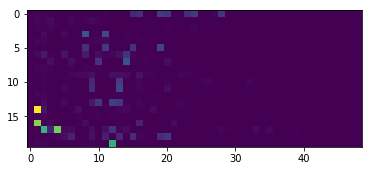

In [43]:
plt.imshow(X_train[:20,:])

In [44]:
X_train = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

In [46]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1395, 49, 1) (1395,)
(599, 49, 1) (599,)


In [47]:
y_data = np.concatenate((y_train, y_test))
y_data = to_categorical(y_data)

In [48]:
y_train = y_data[:1395]
y_test = y_data[1395:]

In [49]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1395, 49, 1)
(599, 49, 1)
(1395, 46)
(599, 46)


## 1. Vanilla RNN
- Vanilla RNNs have a simple structure
- However, they suffer from the problem of "long-term dependencies"
- Hence, they are not able to keep the **sequential memory" for long

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" style="width: 600px"/>

In [50]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

In [51]:
def vanilla_rnn():
    model = Sequential()
    model.add(SimpleRNN(50, input_shape = (49,1), return_sequences = False))
    model.add(Dense(46))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [102]:
model = KerasClassifier(build_fn = vanilla_rnn, epochs = 200, batch_size = 50, verbose = 1)

In [104]:
model.fit(X_train, y_train,verbose=0)

In [105]:
y_pred = model.predict(X_test)

599/599 [==============================] - 0s 466us/step


In [106]:
y_test_ = np.argmax(y_test, axis = 1)

In [107]:
print(accuracy_score(y_pred, y_test_))

0.7562604340567612


## 2. Stacked Vanilla RNN
- RNN layers can be stacked to form a deeper network

<img src="https://lh6.googleusercontent.com/rC1DSgjlmobtRxMPFi14hkMdDqSkEkuOX7EW_QrLFSymjasIM95Za2Wf-VwSC1Tq1sjJlOPLJ92q7PTKJh2hjBoXQawM6MQC27east67GFDklTalljlt0cFLZnPMdhp8erzO" style="width: 500px"/>

In [52]:
def stacked_vanilla_rnn():
    model = Sequential()
    model.add(SimpleRNN(50, input_shape = (49,1), return_sequences = True))   # return_sequences parameter has to be set True to stack
    model.add(SimpleRNN(50, return_sequences = False))
    model.add(Dense(46))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [53]:
model = KerasClassifier(build_fn = stacked_vanilla_rnn, epochs = 200, batch_size = 50, verbose = 1)

In [54]:
model.fit(X_train, y_train,verbose=0)

In [111]:
y_pred = model.predict(X_test)

599/599 [==============================] - 0s 496us/step


In [112]:
print(accuracy_score(y_pred, y_test_))

0.7378964941569283


## 3. LSTM
- LSTM (long short-term memory) is an improved structure to solve the problem of long-term dependencies

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" style="width: 600px"/>

In [113]:
from keras.layers import LSTM

In [114]:
def lstm():
    model = Sequential()
    model.add(LSTM(50, input_shape = (49,1), return_sequences = False))
    model.add(Dense(46))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [115]:
model = KerasClassifier(build_fn = lstm, epochs = 200, batch_size = 50, verbose = 1)

In [116]:
model.fit(X_train, y_train,verbose=0)

In [117]:
y_pred = model.predict(X_test)

599/599 [==============================] - 0s 558us/step


In [118]:
# accuracy improves by adopting LSTM structure
print(accuracy_score(y_pred, y_test_))

0.8464106844741235


## 4. Stacked LSTM
- LSTM layers can be stacked as well

In [330]:
def stacked_lstm():
    model = Sequential()
    model.add(LSTM(50, input_shape = (49,1), return_sequences = True))
    model.add(LSTM(50, return_sequences = False))
    model.add(Dense(46))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [331]:
model = KerasClassifier(build_fn = stacked_lstm, epochs = 200, batch_size = 50, verbose = 1)

In [332]:
model.fit(X_train, y_train)

Epoch 1/200
1395/1395 [==============================] - 3s 2ms/step - loss: 2.8715 - acc: 0.6516
Epoch 2/200
1395/1395 [==============================] - 2s 1ms/step - loss: 1.2543 - acc: 0.7147
Epoch 3/200
1395/1395 [==============================] - 1s 744us/step - loss: 1.1720 - acc: 0.7147
Epoch 4/200
1395/1395 [==============================] - 1s 740us/step - loss: 1.1618 - acc: 0.7147
Epoch 5/200
1395/1395 [==============================] - 1s 683us/step - loss: 1.1534 - acc: 0.7147
Epoch 6/200
1395/1395 [==============================] - 1s 745us/step - loss: 1.1342 - acc: 0.7147
Epoch 7/200
1395/1395 [==============================] - 1s 684us/step - loss: 1.0641 - acc: 0.7147
Epoch 8/200
1395/1395 [==============================] - 1s 740us/step - loss: 0.9246 - acc: 0.7541
Epoch 9/200
1395/1395 [==============================] - 2s 1ms/step - loss: 0.8889 - acc: 0.7849
Epoch 10/200
1395/1395 [==============================] - 2s 1ms/step - loss: 0.8463 - acc: 0.7935
Epoch 1

Epoch 83/200
1395/1395 [==============================] - 2s 1ms/step - loss: 0.5688 - acc: 0.8638
Epoch 84/200
1395/1395 [==============================] - 1s 857us/step - loss: 0.5669 - acc: 0.8581
Epoch 85/200
1395/1395 [==============================] - 1s 840us/step - loss: 0.5555 - acc: 0.8659
Epoch 86/200
1395/1395 [==============================] - 1s 961us/step - loss: 0.5772 - acc: 0.8523
Epoch 87/200
1395/1395 [==============================] - 1s 913us/step - loss: 0.5552 - acc: 0.8674
Epoch 88/200
1395/1395 [==============================] - 1s 952us/step - loss: 0.5344 - acc: 0.8674
Epoch 89/200
1395/1395 [==============================] - 1s 856us/step - loss: 0.5253 - acc: 0.8703
Epoch 90/200
1395/1395 [==============================] - 1s 775us/step - loss: 0.5246 - acc: 0.8688
Epoch 91/200
1395/1395 [==============================] - 1s 922us/step - loss: 0.5444 - acc: 0.8659
Epoch 92/200
1395/1395 [==============================] - 1s 905us/step - loss: 0.5182 - acc:

In [333]:
y_pred = model.predict(X_test)

599/599 [==============================] - 1s 1ms/step


In [334]:
print(accuracy_score(y_pred, y_test_))

0.8497495826377296
